In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

from pyvbmc import VBMC
import random
import os
from tqdm import tqdm

# Params

In [2]:
V_A = 1.1
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.05
t_E_aff = 0
t_motor = 0

Z_E = 0
L = 0.5

N_sim = int(50e3)
dt = 1e-4

N_print = int(100e5)

t_stim_0 = 0.2
t_stim_tau = 0.4

T_trunc = 0.3

# simualted data

In [3]:
def psiam_tied_data_gen_wrapper(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                t_stim_0, t_stim_tau, iter_num, N_print, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    # t_stim is picked from a distribution
    t_stim = np.random.exponential(t_stim_tau) + t_stim_0

    # print after every N_print iterations
    if iter_num % N_print == 0:
        print(f'In iter_num: {iter_num}, ABL: {ABL}, ILD: {ILD}, t_stim: {t_stim}')


    choice, rt, is_act = simulate_psiam_tied(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim}

def simulate_psiam_tied(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, dt):
    AI = 0; DV = Z_E; t = 0; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    
    is_act = 0
    while True:
        if t*dt > t_stim + t_E_aff:
            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        if t*dt > t_A_aff:
            AI += V_A*dt + np.random.normal(0, dB)
        
        t += 1
        
        if DV >= theta:
            choice = +1; RT = t*dt + t_motor
            break
        elif DV <= -theta:
            choice = -1; RT = t*dt + t_motor
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t*dt
            # if t*dt > t_stim - t_motor:
            while t*dt <= (AI_hit_time + t_E_aff + t_motor):#  u can process evidence till stim plays
                if t*dt > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        break
                    elif DV <= -theta:
                        DV = -theta
                        break
                t += 1
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time + t_motor
        # if DV != 0:
        if DV >= (1 + (L/2) - 1)*theta:
            choice = 1
        elif DV <= (1 - (L/2) - 1)*theta:
            choice = -1
        else:
            prob_hit_up = (1/L)*((DV/theta) + 1) + (0.5 - (1/L))            
            if np.random.rand() <= prob_hit_up:
                choice = 1
            else:
                choice = -1
        # if DV > 0:
        #     choice = 1
        # elif DV < 0:
        #     choice = -1
        # else: # if DV is 0 because stim has not yet been played, then choose right/left randomly
        #     randomly_choose_up = np.random.rand() >= 0.5
        #     if randomly_choose_up:
        #         choice = 1
        #     else:
        #         choice = -1       
    
    return choice, RT, is_act

# ABL ILD

In [4]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# simulate

In [5]:
sim_results = Parallel(n_jobs=-1)(
            delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, \
                                                  t_A_aff, t_E_aff, t_motor, L, t_stim_0, t_stim_tau, iter_num, N_print, dt)
            for iter_num in tqdm(range(N_sim))
        )

# V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
#                                 t_stim_0, t_stim_tau, iter_num, N_print, dt

  0%|          | 32/50000 [00:00<03:35, 232.17it/s]

In iter_num: 0, ABL: 60, ILD: -4.0, t_stim: 0.7551829512633617


100%|██████████| 50000/50000 [00:14<00:00, 3493.06it/s]


# Helper funcs for likeli

In [6]:
from scipy.special import erf
def Phi(x):
    """
    Define the normal cumulative distribution function Φ(x) using erf
    """
    return 0.5 * (1 + erf(x / np.sqrt(2)))

def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


def cum_A_t_fn(t, V_A, theta_A):
    """
    For AI, calculate cummulative distrn of a time t given V_A, theta_A
    """
    if t <= 0:
        return 0

    term1 = Phi(V_A * ((t) - (theta_A/V_A)) / np.sqrt(t))
    term2 = np.exp(2 * V_A * theta_A) * Phi(-V_A * ((t) + (theta_A / V_A)) / np.sqrt(t))
    
    return term1 + term2


# VBMC

In [7]:
def compute_loglike(res, V_A, theta_A, t_A_aff):
    t_stim = res['t_stim']
    rt = res['rt']

    rt -= t_A_aff
    pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, V_A, theta_A) # trunc factor

    if rt < T_trunc:
        likelihood = 0
    elif rt < t_stim: # abort
        likelihood = rho_A_t_fn(rt, V_A, theta_A) / pdf_trunc_factor
    elif rt > t_stim: # censor
        likelihood = 1 - (cum_A_t_fn(t_stim, V_A, theta_A)/pdf_trunc_factor)
        

    
    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    V_A, theta_A, t_A_aff = params

    all_loglike = Parallel(n_jobs=1)(delayed(compute_loglike)(res, V_A, theta_A, t_A_aff) for res in sim_results )

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [8]:
V_A_bounds = [0.1, 5]
theta_A_bounds = [0.1, 5]
t_A_aff_bounds = [0.03, 0.06]

V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [0.5, 3]
t_A_plausible_bounds = [0.035, 0.05]

# prior

In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A, theta_A, t_A_aff = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_plausible_bounds[0], t_A_plausible_bounds[1], t_A_aff_bounds[1])

    return V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# prior + loglike

In [10]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [11]:
lb = [V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]


plb = [V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_plausible_bounds[0]]
pub = [V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_plausible_bounds[1]]

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
NDT_0 = np.random.uniform(t_A_plausible_bounds[0], t_A_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, NDT_0])


In [12]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).


/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/acquisition_functions/acq_fcn_log.py:48: RuntimeWarning: divide by zero encountered in log
  acq = -(np.log(var_tot) + f_bar - z + log_p)


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -453426.493 +/-36043.439.
Caution: Returned variational solution may have not converged.


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


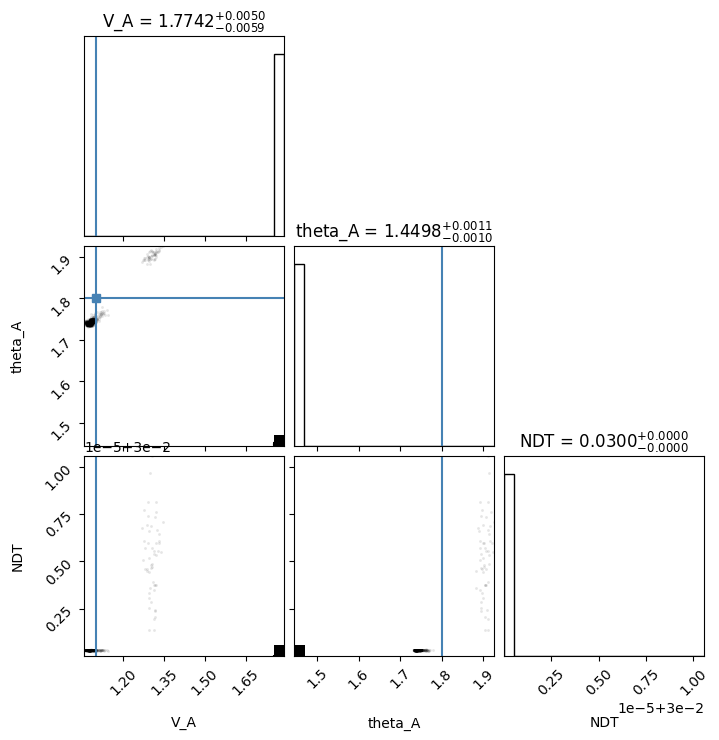

In [13]:
import corner
vp_samples = vp.sample(int(1e6))[0]
V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
NDT_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((V_A_samp, theta_A_samp, NDT_samp)))
param_labels = ['V_A', 'theta_A', 'NDT']
true_params = [V_A, theta_A, t_A_aff]
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f", truths=true_params  );


# RTD

In [14]:
def rho_A_t_fn(t, V_A, theta_A, NDT):
    """
    For AI,prob density of t given V_A, theta_A
    """
    t -= NDT
    if t < 0:
        return 0
    rho = (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))
    return rho

def stim_surive_fn(t):
    """
    Prob that stim survives till time t =  1 - _ana(P_stim)
    """
    if t < 0.2:
        return 1
    p_stim_surive = np.exp(- (t - 0.2)/0.4)
    return p_stim_surive

def rho_A_t_and_stim_survive(t, V_A, theta_A, NDT):
    """
    prob that AI hit and stim survive till time t
    """
    return rho_A_t_fn(t, V_A, theta_A, NDT)*stim_surive_fn(t)

def rho_A_t_and_stim_survive_truncated(t, V_A, theta_A, NDT, pdf_trunc_factor):
    """
    prob that AI hit and stim survive, but truncated at T_trunc. 
    """
    if t < T_trunc:
        return 0
    return rho_A_t_and_stim_survive(t, V_A, theta_A, NDT)*pdf_trunc_factor

def area_for_rho_A_t_stim_survive_trunc_0_to_inf(V_A, theta_A, NDT, pdf_factor):
    """
    Area under the curve of rho_A_t_and_stim_survive_truncated from 0 to inf
    """
    area = quad(rho_A_t_and_stim_survive_truncated, 0, np.inf, args=(V_A, theta_A, NDT, pdf_factor))[0]
    return area

def pdf_trunc_factor_for_stim_surive_trunc(V_A, theta_A, NDT):
    """
    Factor to normalize the truncated pdf
    """
    return 1/(1 - quad(rho_A_t_and_stim_survive, 0, T_trunc, args=(V_A, theta_A, NDT))[0])

def rho_A_t_stim_survive_truncated_and_norm(t, V_A, theta_A, NDT, area, pdf_factor):
    """
    prob that AI hit and stim surive but truncated and ALSO normalized
    """
    return rho_A_t_and_stim_survive_truncated(t, V_A, theta_A, NDT, pdf_factor)/area

In [15]:
V_A_samp_mean = np.mean(V_A_samp)
theta_A_samp_mean = np.mean(theta_A_samp)
t_A_aff_samp_mean = np.mean(NDT_samp)

TypeError: rho_A_t_fn() missing 1 required positional argument: 'NDT'

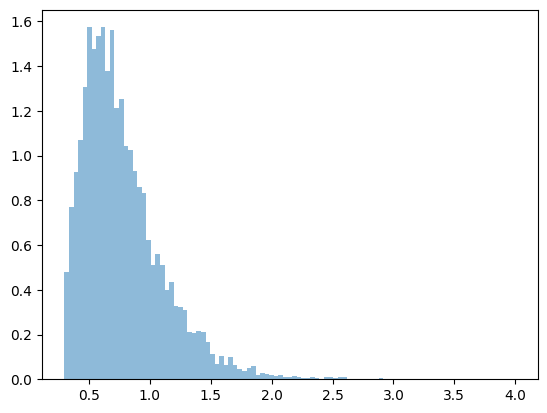

In [16]:
# sim data
sim_aborts = [res['rt'] for res in sim_results if res['rt'] > T_trunc and res['rt'] < res['t_stim']]

bins = np.linspace(T_trunc, 4, 100)
plt.hist(sim_aborts, bins=bins, density=True, alpha=0.5, label='simulated')

# theory
t_pts = bins[:-1] + np.diff(bins)/2
theory = np.array([(res['rt'], np.exp(compute_loglike(res, V_A_samp_mean, theta_A_samp_mean, t_A_aff_samp_mean))) \
                    for res in sim_results if res['rt'] > T_trunc])

plt.plot(theory[:,0], theory[:,1], label='theory')


# PSTH